In [2]:
import matplotlib.pyplot as plt # библиотека для построения графиков и диаграмм
import numpy as np              # библиотека для научных вычислений и работы с массивами чисел
import os                       # библиотека для работы с файлами и каталогами операционной системы
import pandas as pd             # библиотека для работы с табличными данными
import pickle                   # Сохранение/загрузка словаря
import pydicom                  # библиотека для работы с DICOM-изображениями в медицине.

from math import floor          # математическая библиотека Python
from PIL import Image           # библиотека для работы с изображениями
from sklearn.model_selection import train_test_split # Разбиение на тренировочную и тестовую выборки
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Матрица ошибок классификатора

# для создания сети
import tensorflow as tf
from tensorflow.keras.models import Sequential
# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, SpatialDropout2D
# для работы с изображениями
from tensorflow.keras.preprocessing import image
# оптимизатор
from tensorflow.keras.optimizers import Adam 

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Анализ набора данных

https://mosmed.ai/en/datasets/aie21selftestmri/

```python
# возьмем первые 6 папок. Это примерно 500 000 изображений внутри dcm
pd.read_csv('labels_df_plus.csv')['major_dir'].value_counts().sort_values()
```
```
PAN_BOT_anon             22
ING15_GB3_anon           24
INTERA_GKB12_anon        25
MRI84653_anon            29
EXCELMRI_GP22_anon      369
EXCELMRI_DC3_anon       481
EXCELMRI_GP8_anon       536
EXCELMRI_GVV2_anon      681
EXCELMRI_GKB71_anon     691
EXCELMRI_GKB57_anon     718
EXCELMRI_GP9_anon       818
HDX_MR_anon             828
EXCELMR_GB13_anon       830
EXCELMR_VERES_anon      832
EXCELMRI_GP134_anon     885
EXCELMRI_GKB36_anon     957
EXCELMRI_GP19_anon      967
EXCELMRI_GP209_anon    1086
EXCELMRI_GP212_anon    1154
EXCELMRI_GP214_anon    1204
EXCELMRI_GKB50_anon    1226
EXCELMRI_GP195_anon    1302
EXCELMRI_KDC4_anon     1306
EXCELMRI_GVV3_anon     1315
MR_GP46F1_anon         1339
EXCELMRI_GP52_anon     1359
EXCELMRI_GP67_anon     1392
EXCELMRI_GP68_anon     1574
EXCELMRI_MUH_anon      1633
EXCELMR1_GB1_anon      1644
EXCELMR_NPPCS_anon     1717
EXCELMRI_GP45_anon     1718
EXCELMRI_GP6_anon      1764
EXCELMRI_GP220_anon    1816
EXCELMR_YUD_anon       1833
EXCELMRI_GP2_anon      1947
EXCELMRI_KDC6_anon     2035
EXCELMRI_SM4_anon      2102
EXCELMR2_GB1_anon      2113
EXCELMRI_GVV1_anon     2312
ING30_MDGKB_anon       2410
EXCELMRI_GKB29_anon    2873
Name: major_dir, dtype: int64
```
Всего 43 папки. Внутри каждой 4 исследования. Внутри каждого исследования папки с dcm. Общий объем 27 Гб. Для удобства последующей работы, достаем из папок dcm и кладем в одну папку.

```python
%%time
folder = 'nf'
old_folder = 'of'
cols = os.listdir(old_folder)
data = pd.read_csv('labels_df_plus.csv').query(f'major_dir in @cols')

# nf - новая папка, of - старая папка
print('before:')
print(old_folder, os.listdir(old_folder))
print(folder, os.listdir(folder))

# перемещение всех dcm из своих папок по адресу data['path'] в одно место - nf папку
for x in data['path']:
    # путь к файлу, который нужно перенести
    old_path = f'{old_folder}/{x}'

    # путь к новой папке, куда нужно перенести файл
    new_folder = folder

    # создаем новый путь с именем файла из старого пути
    new_path = os.path.join(new_folder, os.path.basename(old_path))

    # перемещаем файл из старой папки в новую
    os.rename(old_path, new_path)

print('\nafter:')
print(old_folder, os.listdir(old_folder))
print(folder, os.listdir(folder))
```
```
before:
of ['EXCELMR1_GB1_anon', 'EXCELMR2_GB1_anon', 'EXCELMRI_DC3_anon', 'EXCELMRI_GKB29_anon', 'EXCELMRI_GKB36_anon', 'EXCELMRI_GKB50_anon', 'EXCELMRI_GKB57_anon', 'EXCELMRI_GKB71_anon', 'EXCELMRI_GP134_anon', 'EXCELMRI_GP195_anon', 'EXCELMRI_GP19_anon', 'EXCELMRI_GP210_anon', 'EXCELMRI_GP212_anon', 'EXCELMRI_GP214_anon', 'EXCELMRI_GP220_anon', 'EXCELMRI_GP22_anon', 'EXCELMRI_GP2_anon', 'EXCELMRI_GP45_anon', 'EXCELMRI_GP52_anon', 'EXCELMRI_GP67_anon', 'EXCELMRI_GP68_anon', 'EXCELMRI_GP8_anon', 'EXCELMRI_GP9_anon', 'EXCELMRI_GVV1_anon', 'EXCELMRI_GVV2_anon', 'EXCELMRI_GVV3_anon', 'EXCELMRI_KDC6_anon', 'EXCELMRI_MUH_anon', 'EXCELMR_GB13_anon', 'EXCELMR_NPPCS_anon', 'EXCELMR_VERES_anon', 'HDX_MR_anon', 'ING15_GB3_anon', 'ING30_MDGKB_anon', 'INTERA_GKB12_anon', 'MRI84653_anon', 'MR_GP46F1_anon', 'PAN_BOT_anon']
nnf []

after:
of ['EXCELMR1_GB1_anon', 'EXCELMR2_GB1_anon', 'EXCELMRI_DC3_anon', 'EXCELMRI_GKB29_anon', 'EXCELMRI_GKB36_anon', 'EXCELMRI_GKB50_anon', 'EXCELMRI_GKB57_anon', 'EXCELMRI_GKB71_anon', 'EXCELMRI_GP134_anon', 'EXCELMRI_GP195_anon', 'EXCELMRI_GP19_anon', 'EXCELMRI_GP210_anon', 'EXCELMRI_GP212_anon', 'EXCELMRI_GP214_anon', 'EXCELMRI_GP220_anon', 'EXCELMRI_GP22_anon', 'EXCELMRI_GP2_anon', 'EXCELMRI_GP45_anon', 'EXCELMRI_GP52_anon', 'EXCELMRI_GP67_anon', 'EXCELMRI_GP68_anon', 'EXCELMRI_GP8_anon', 'EXCELMRI_GP9_anon', 'EXCELMRI_GVV1_anon', 'EXCELMRI_GVV2_anon', 'EXCELMRI_GVV3_anon', 'EXCELMRI_KDC6_anon', 'EXCELMRI_MUH_anon', 'EXCELMR_GB13_anon', 'EXCELMR_NPPCS_anon', 'EXCELMR_VERES_anon', 'HDX_MR_anon', 'ING15_GB3_anon', 'ING30_MDGKB_anon', 'INTERA_GKB12_anon', 'MRI84653_anon', 'MR_GP46F1_anon', 'PAN_BOT_anon']
nnf ['1.2.643.5.1.13.13.12.2.77.8252.00000714140703000808060911111204.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00000902020506010010091008030701.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00001013111110121502060803040209.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00010401050914070611140603040602.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00020002030302140206020913030610.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00020801100303120613020015080009.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00021102130403010413030701000307.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00030401090301130301100008140612.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00031113020801130315140210061203.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00040208000809011100100702110908.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00040400030209130115101012020410.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00041413140611060812050310101500.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00050300120907040811130403070012.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00050502031214140609131208150512.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00050901050214030503130914110212.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00051215100915061300051115071403.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00051405070101050714130607060215.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00051512120912081014091400130707.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00070007001306001405001106061501.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00070804111311121511150900011411.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00080509060300040813140214041015.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00080715030402041310140701000314.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00081007100700060309120005040015.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00090301130001140115091206011204.dcm', '1.2.643.5.1.13.13.12.2.77.8252.00090805080606111406141315021302.dcm', 
...]
```

In [3]:
# конвертация dcm набора фотографий
def read_dicom_image(path):
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array.astype(np.float32) #преобразование изображения в numpy-массив
    intercept = dcm.RescaleIntercept if 'RescaleIntercept' in dcm else 0.0
    slope = dcm.RescaleSlope if 'RescaleSlope' in dcm else 1.0
    img = slope * img + intercept #масштабирование
    return img#.reshape(1,img.shape[0]*img.shape[1]) # Изменение формы входных картинок с shape(a,b) на shape(1,a*b)

Проверим размер изображений в dcm из разных папок.

```python
# Примеры матриц dcm из разных папок
s = np.array([read_dicom_image('destination_folder/'+x) for x in os.listdir('destination_folder')], dtype=object)
print(s)

# размеры изображений
print('\n',[x.shape for x in s])

print('\nmin:',np.min([x.shape for x in s]), 'max:',np.max([x.shape for x in s]))
```
```
[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[630., 763., 791., ..., 653., 708., 663.],
        [599., 553., 528., ..., 588., 655., 695.],
        [620., 638., 536., ..., 570., 598., 645.],
        ...,
        [274., 302., 320., ..., 343., 335., 308.],
        [265., 297., 299., ..., 298., 273., 256.],
        [278., 309., 296., ..., 309., 295., 289.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[11., 15., 12., ...,  1.,  7., 16.],
        [12., 13., 12., ...,  3.,  9., 13.],
        [14., 17., 15., ...,  3., 12., 15.],
        ...,
        [13., 10., 10., ..., 18., 17., 17.],
        [16., 16., 15., ..., 21., 19., 12.],
        [12., 18., 20., ..., 20., 13.,  9.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[ 6.,  2.,  0., ...,  0.,  0.,  0.],
        [ 6.,  2.,  0., ...,  0.,  0.,  2.],
        [ 6.,  1.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 5., 20.,  0., ...,  0., 18., 13.],
        [13., 25.,  0., ..., 13., 19., 18.],
        [22., 17., 17., ..., 20., 20., 14.]], dtype=float32)
 array([[526., 560., 542., ..., 639., 597., 491.],
        [625., 640., 569., ..., 725., 707., 649.],
        [586., 625., 514., ..., 671., 618., 668.],
        ...,
        [390., 341., 332., ..., 456., 446., 407.],
        [414., 403., 380., ..., 435., 414., 361.],
        [426., 435., 418., ..., 430., 406., 347.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[[1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         ...,
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.]],

        [[1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         ...,
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.]],

        [[1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         ...,
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.]],

        ...,

        [[1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         ...,
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.]],

        [[1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         ...,
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.]],

        [[1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         ...,
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.],
         [1150., 1150., 1150., ..., 1150., 1150., 1150.]]], dtype=float32)
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[[1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         ...,
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.]],

        [[1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         ...,
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.]],

        [[1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         ...,
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.]],

        ...,

        [[1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         ...,
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.]],

        [[1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         ...,
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.]],

        [[1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         ...,
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.],
         [1607., 1607., 1607., ..., 1607., 1607., 1607.]]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[ 235.,  145.,  198., ...,  255.,  225.,  267.],
        [ 279.,  253.,  296., ...,  308.,  256.,  265.],
        [ 254.,  256.,  280., ...,  256.,  266.,  250.],
        ...,
        [ 198.,  259.,  250., ...,  951., 1131., 1431.],
        [ 248.,  259.,  269., ..., 1056., 1387., 1546.],
        [ 277.,  228.,  271., ..., 1351., 1397., 1506.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[104., 145., 175., ...,  92., 103., 102.],
        [120., 147., 124., ..., 104.,  89.,  86.],
        [131., 125., 110., ...,  99., 120., 100.],
        ...,
        [115., 121., 106., ...,  93.,  99.,  90.],
        [121., 105.,  97., ...,  87.,  84.,  82.],
        [116.,  91., 108., ...,  89.,  85.,  77.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

 [(384, 416), (748, 640), (384, 384), (512, 512), (384, 384), (768, 768), (288, 288), (640, 640), (384, 384), (384, 384), (768, 768), (22, 192, 192), (384, 384), (768, 768), (640, 640), (512, 512), (768, 768), (384, 384), (576, 576), (384, 384), (384, 384), (768, 768), (768, 768), (384, 384), (768, 768), (576, 576), (23, 192, 192), (48, 128, 128), (512, 512), (25, 192, 192), (768, 768), (192, 192), (384, 384), (384, 384), (384, 384), (512, 512), (640, 640), (768, 768), (512, 512), (640, 640), (384, 384), (768, 768)]

min: (22, 192, 192) max: (768, 768)
```

Перед обучением, нужно будет привести картинки к общему размеру. Например 384*384

Идем дальше. Проверим работоспособность dcm. Создал для этого папку destination_folder в которой поместил по одному dcm из каждой папки.

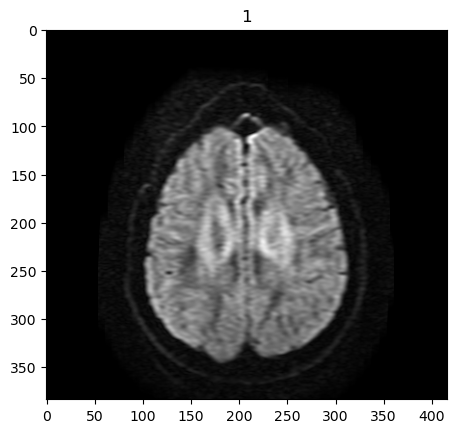

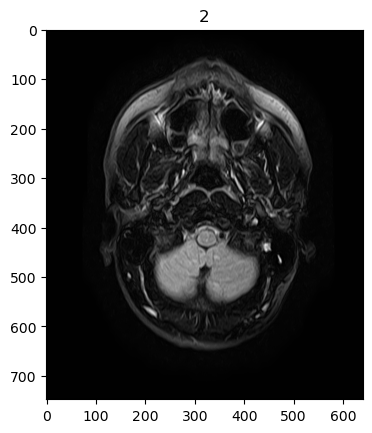

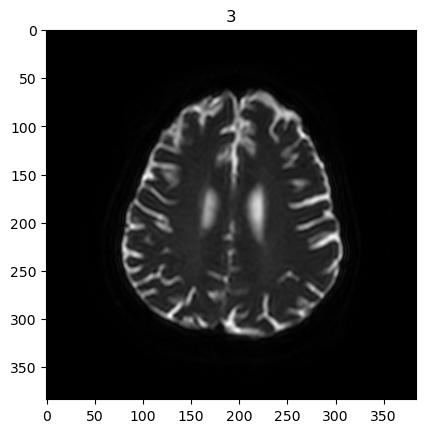

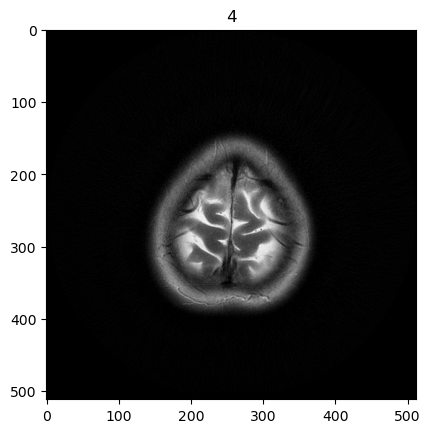

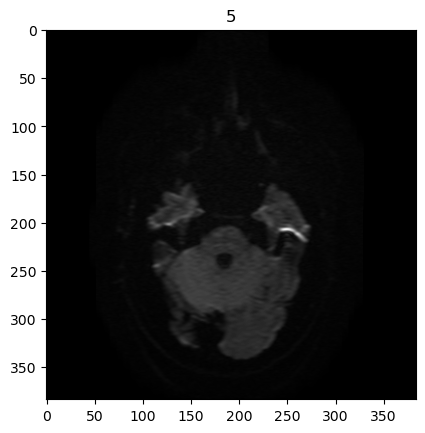

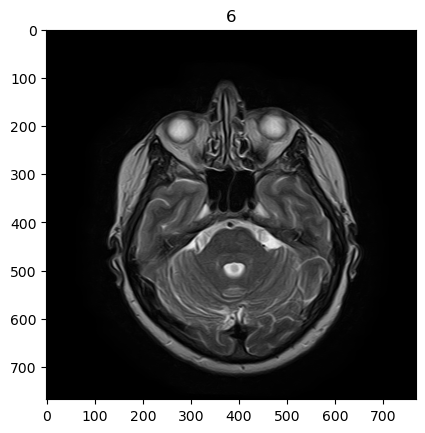

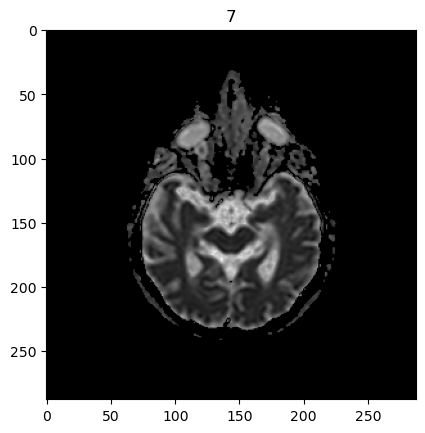

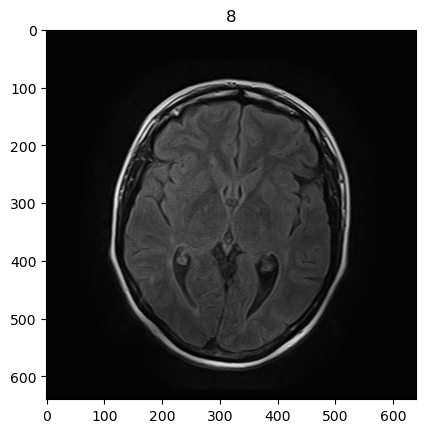

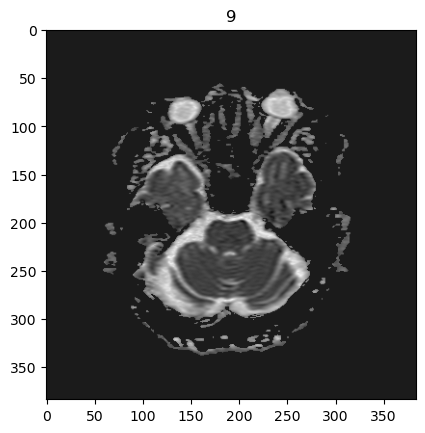

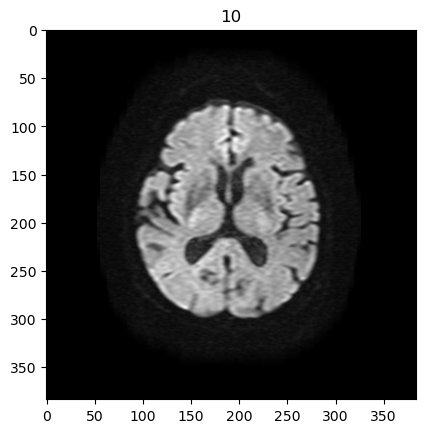

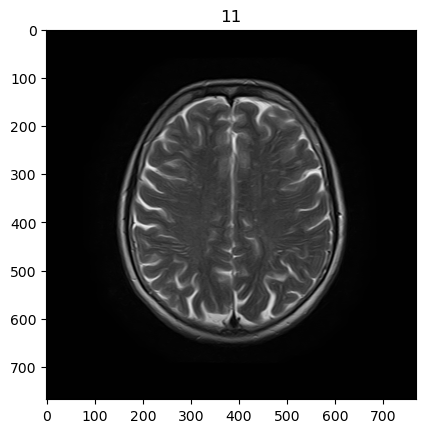

Ошибка  EXCELMRI_GP220_anon


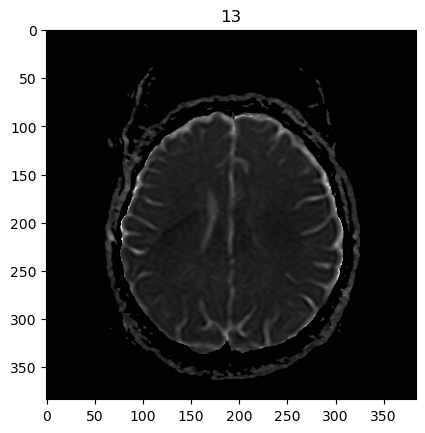

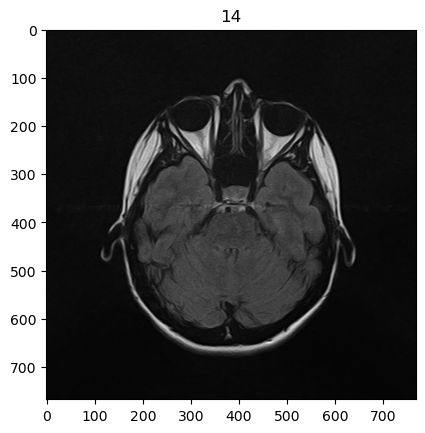

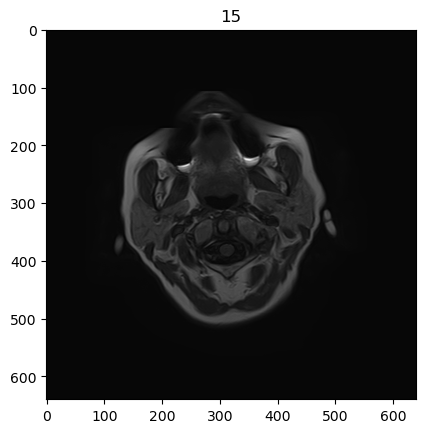

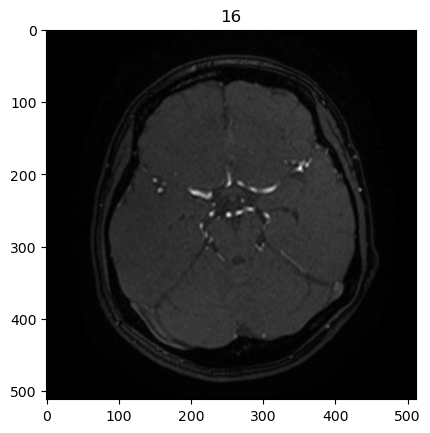

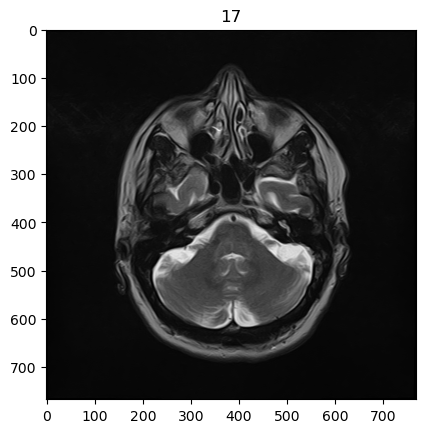

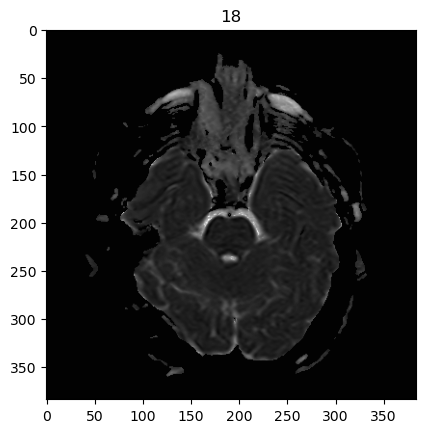

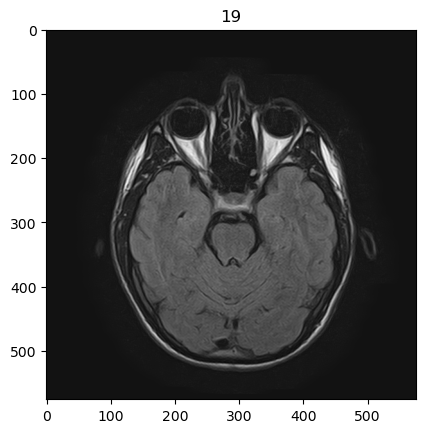

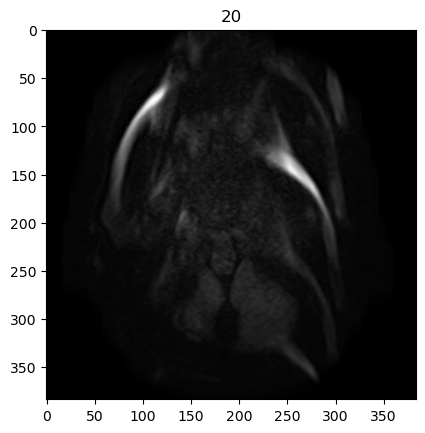

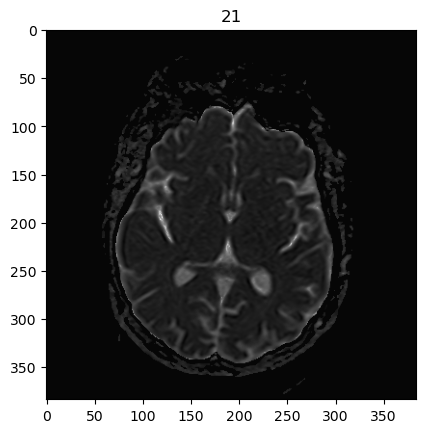

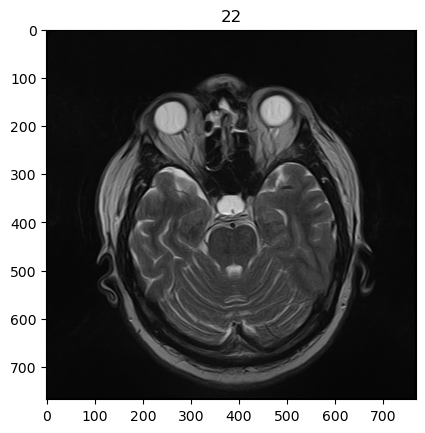

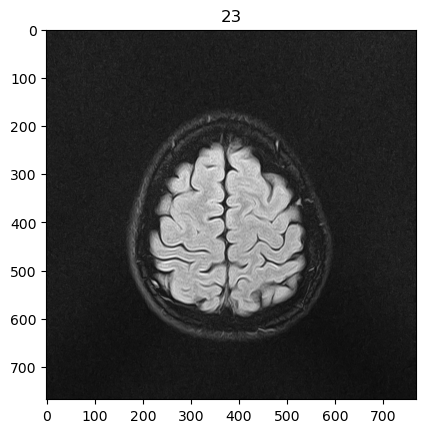

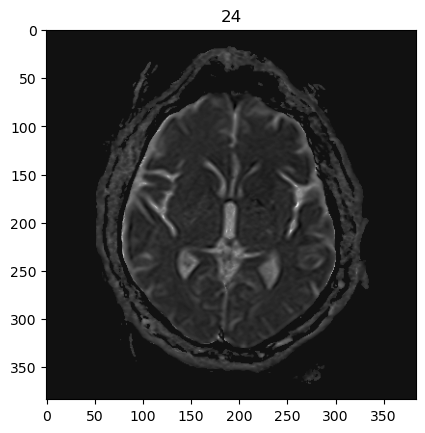

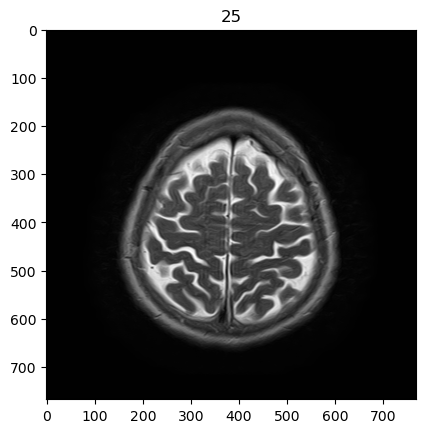

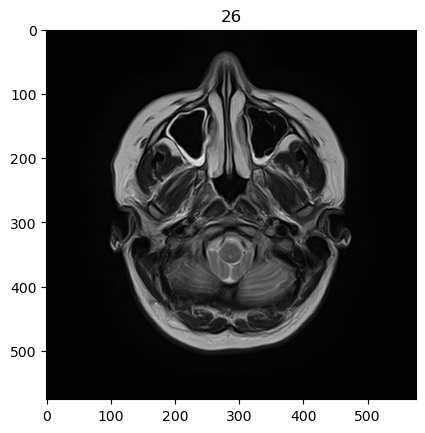

Ошибка  EXCELMRI_GVV2_anon
Ошибка  EXCELMRI_SM4_anon


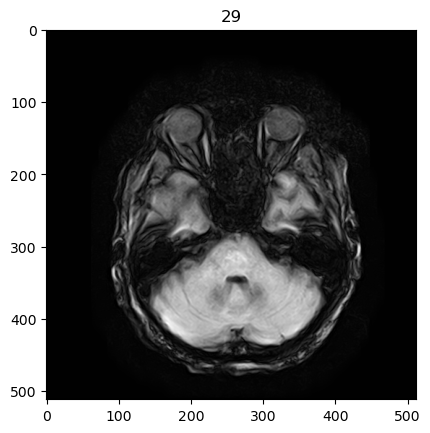

Ошибка  EXCELMRI_GP195_anon


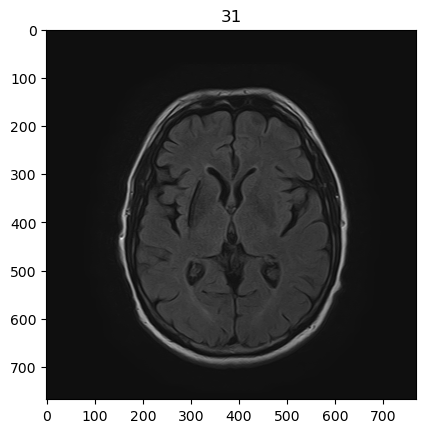

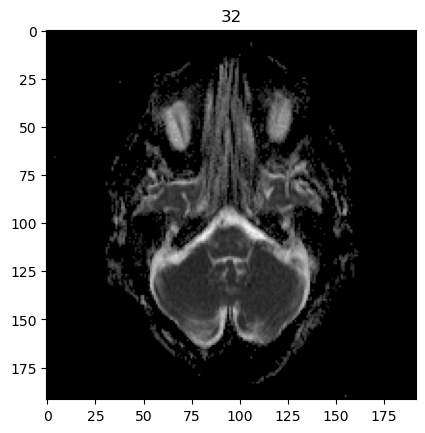

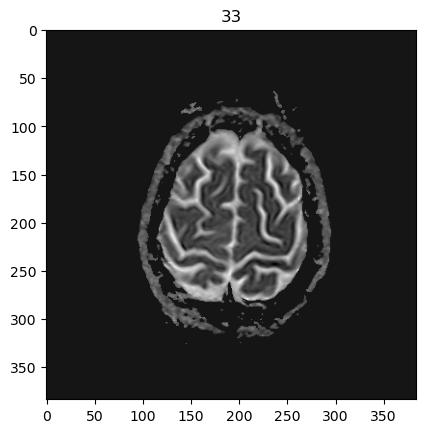

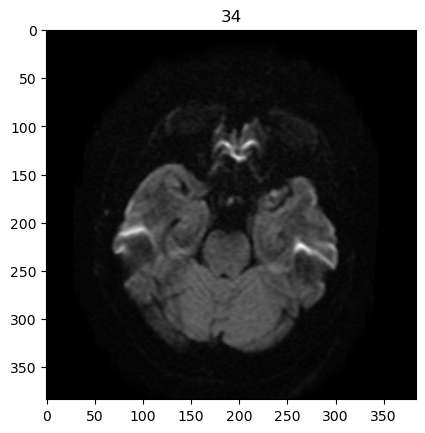

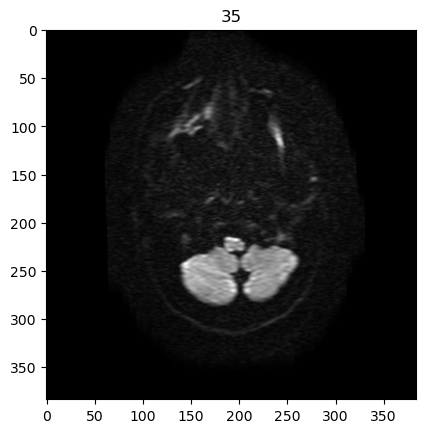

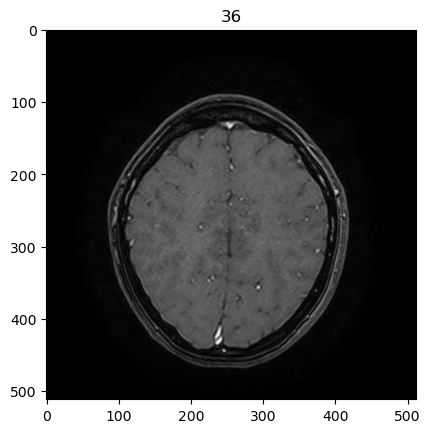

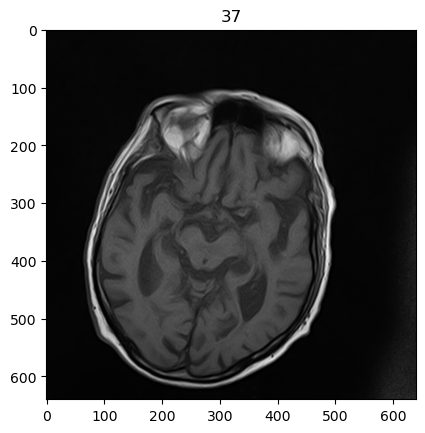

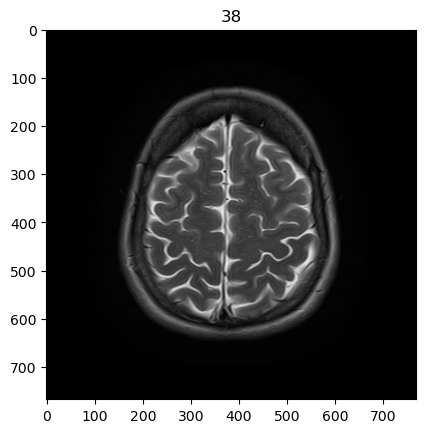

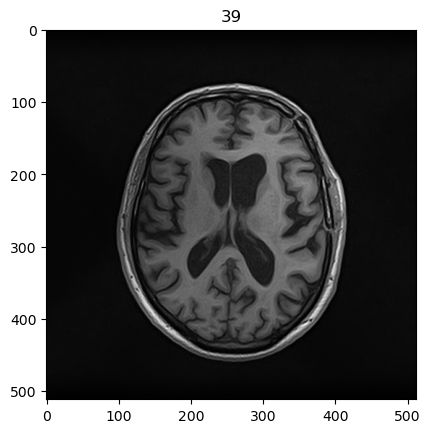

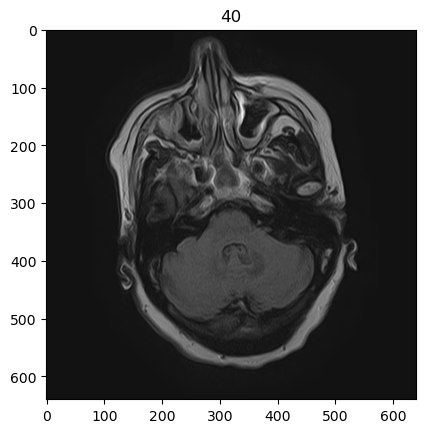

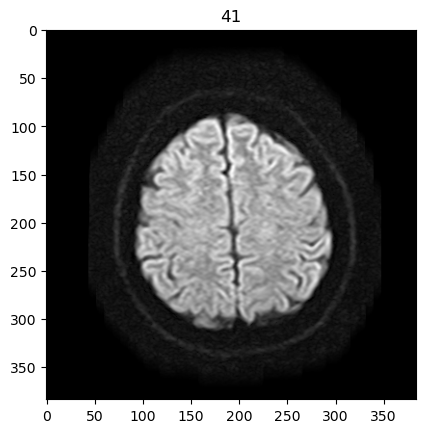

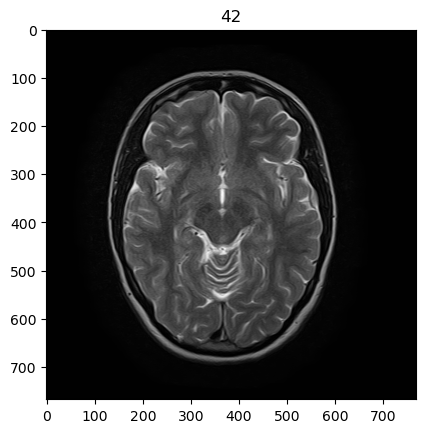

['EXCELMRI_GP220_anon', 'EXCELMRI_GVV2_anon', 'EXCELMRI_SM4_anon', 'EXCELMRI_GP195_anon']
CPU times: total: 6.88 s
Wall time: 6.91 s


In [4]:
%%time
def test(folder):
    path = pd.DataFrame()
    path['dcm'] = pd.Series(os.listdir(folder))
    path['path'] = f'{folder}/' + path['dcm']

    l = path['dcm'].tolist()
    path['major_dir'] = pd.read_csv('labels_df_plus.csv').query('dcm in @l').reset_index()['major_dir']

    error = []
    folder_n = 1

    for i in range(len(path)):
        try:
            x = read_dicom_image(path.loc[i, 'path']).tolist()
            plt.title(folder_n)
            plt.imshow(x, cmap='gray')
            plt.show()
        except:
            print('Ошибка ',path.loc[i, 'major_dir'])
            error.append(path.loc[i, 'major_dir'])
        folder_n +=1

    print(error)

test('destination_folder')

Что то не так c некоторыми папками или dcm. Нужно проверить на других dcm из проблемных папок. Создадим новый фолдер destination_folder_2.

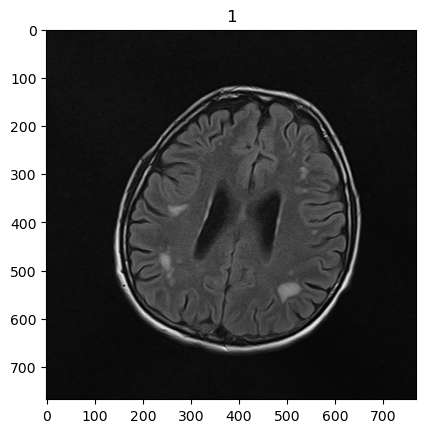

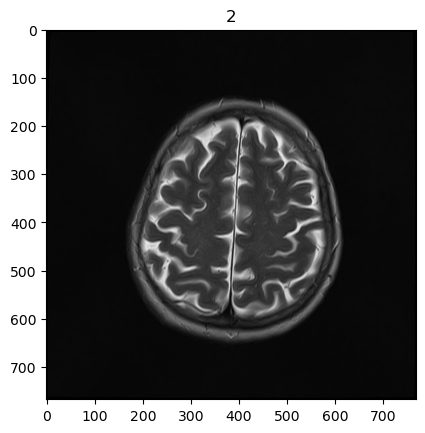

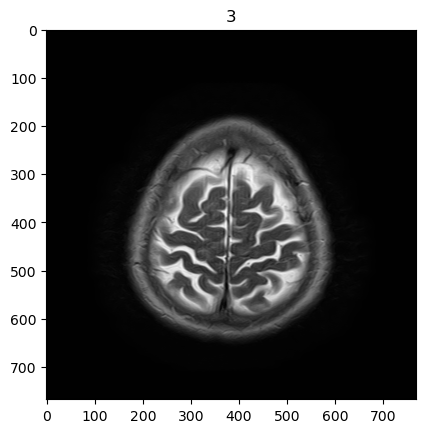

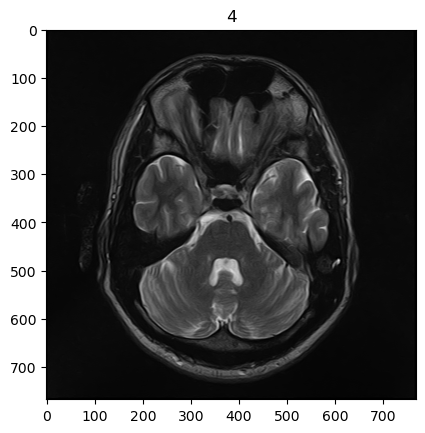

[]
CPU times: total: 1.02 s
Wall time: 1.01 s


In [5]:
%%time
path = pd.DataFrame()
path['dcm'] = pd.Series(os.listdir('destination_folder_2'))
path['path'] = 'destination_folder_2/' + path['dcm']

l = path['dcm'].tolist()
path['major_dir'] = pd.read_csv('labels_df_plus.csv').query('dcm in @l').reset_index()['major_dir']

error = []
folder_n = 1

for i in range(len(path)):
    try:
        x = read_dicom_image(path.loc[i, 'path']).tolist()
        plt.title(folder_n)
        plt.imshow(x, cmap='gray')
        plt.show()
    except:
        print('Ошибка ',path.loc[i, 'major_dir'])
        error.append(path.loc[i, 'major_dir'])
    folder_n +=1
        
print(error)

Угу. Все впорядке с папками, есть проблемы с файлами dcm. Учтем.

# Предобработка

In [6]:
# Задание высоты и ширины загружаемых изображений
IMG_HEIGHT = 194
IMG_WIDTH = 194

dct = {} # Пустой словарь для данных изображений
folder = 'nf' # расположение всех dcm

for file_name in os.listdir(folder)[:100]:
    try:
        path = f'{folder}/'+ file_name                            # путь от тетрадки до dcm
        img = read_dicom_image(path)                              # конвертация dcm в матрицу
        img = Image.fromarray(np.uint8(img)).resize((IMG_HEIGHT, IMG_WIDTH)).convert("L") # Открытие и смена размера изображения
        #img.save("my_image.jpg")                                 # Сохраняем изображение в формате .jpg
        img_np = np.array(img)                                    # Перевод в numpy-массив                             
        dct[file_name] = img_np                                   # Добавление изображения в виде numpy-массива к общему списку
    except:
        print(file_name) # вывести на экран название dcm, которое нельзя открыть, конвертировать и сохранить в словаре

x_data = (np.array(list(dct.values()))                            # Перевод общего списка изображений в numpy-массив
            .reshape(-1,IMG_HEIGHT,IMG_WIDTH,1)                   # подготовка к обучению
            /255                                                  # нормализация даных
         ) 

k = dct.keys()
data_labels = pd.read_csv('labels_df_plus.csv').query('dcm in @k').reset_index()['sclerosis']
y_data = np.array(data_labels)                                    # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(dct)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

print('\n\nПолучение индексов разделения основного набора на обучающую и тестовую выборки')
idx_train, idx_test = train_test_split(list(range(len(x_data))),
                                       stratify=y_data,
                                       test_size=0.2)

print('Разделение в соответствии с полученными индексами')
x_train, x_test = x_data[idx_train], x_data[idx_test]
y_train, y_test = y_data[idx_train], y_data[idx_test]

# Проверка результата
print('x_train.shape, x_test.shape')
print(x_train.shape, x_test.shape)
print('y_train.shape, y_test.shape')
print(y_train.shape, y_test.shape)

В массив собрано 100 фотографий следующей формы: (194, 194)
Общий массив данных изображений следующей формы: (100, 194, 194, 1)
Общий массив меток классов следующей формы: (100,)


Получение индексов разделения основного набора на обучающую и тестовую выборки
Разделение в соответствии с полученными индексами
x_train.shape, x_test.shape
(80, 194, 194, 1) (20, 194, 194, 1)
y_train.shape, y_test.shape
(80,) (20,)


```python
file_name = 'my_dict'
my_dict = x_data

# Сохраняем словарь в файл
with open(f'{file_name}.pickle', 'wb') as f:
    pickle.dump(my_dict, f)

# Загружаем словарь из файла
with open(f'{file_name}.pickle', 'rb') as f:
    loaded_dict = pickle.load(f)

# тест    
plt.imshow(loaded_dict[0])
```

# Модель

In [7]:
img_height = IMG_HEIGHT # Высота 
img_width = IMG_WIDTH # Ширина 
chanels = 1 # Количество каналов  

input_shape = (img_height, img_width, chanels)

Количество фильтров возрастает, а размер изображения убывает. Это один из действенных способов классифицировать изображения сверточными сетями.

Любое изображение с точки зрения математики представляет собой совокупность правил взаимного расположения элементов. Соотв. чем больше фильтров ищут признаки, тем выше шанс.

In [8]:
model = Sequential()

# 1
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(input_shape)))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.5))

# 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.5))


model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# 2
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())                            
# model.add(SpatialDropout2D(0.5))

# # 2
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization())                            
# model.add(SpatialDropout2D(0.5))

# # 2
# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())                            
# model.add(SpatialDropout2D(0.5))

# # 3
# model.add(BatchNormalization())
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))                             # 9*6
# model.add(SpatialDropout2D(0.3))

# # 4
# model.add(BatchNormalization())
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))                             # 3*2
# model.add(SpatialDropout2D(0.3))

# # 5
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(SpatialDropout2D(0.3))

model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='elu'))
model.add(Dense(2, activation='softmax')) # Выходной полносвязный слой с количеством нейронов 1, т.к. бинарная классификация

Epoch 1/50
4/4 [==============================] - 9s 2s/step - loss: 1.7368 - accuracy: 0.5375 - val_loss: 0.7263 - val_accuracy: 0.5500
Epoch 2/50
4/4 [==============================] - 6s 1s/step - loss: 1.3145 - accuracy: 0.6875 - val_loss: 1.0965 - val_accuracy: 0.4500
Epoch 3/50
4/4 [==============================] - 6s 1s/step - loss: 1.3923 - accuracy: 0.6500 - val_loss: 1.3404 - val_accuracy: 0.4500
Epoch 4/50
4/4 [==============================] - 6s 1s/step - loss: 0.7419 - accuracy: 0.7375 - val_loss: 1.7242 - val_accuracy: 0.4500
Epoch 5/50
4/4 [==============================] - 6s 1s/step - loss: 1.0806 - accuracy: 0.5875 - val_loss: 1.7892 - val_accuracy: 0.4500
Epoch 6/50
4/4 [==============================] - 6s 1s/step - loss: 0.8795 - accuracy: 0.6500 - val_loss: 2.0176 - val_accuracy: 0.4500
Epoch 7/50
4/4 [==============================] - 6s 1s/step - loss: 0.7972 - accuracy: 0.7125 - val_loss: 2.1752 - val_accuracy: 0.4500
Epoch 8/50
4/4 [=========================

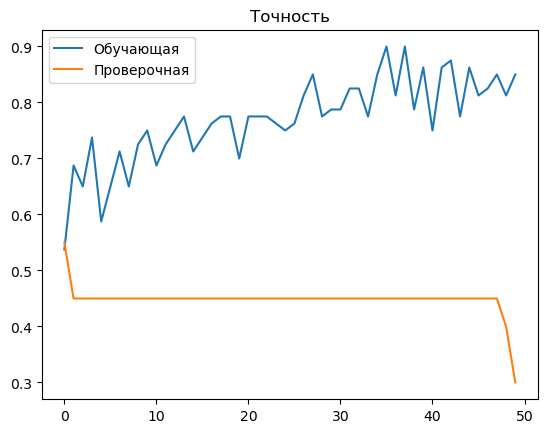

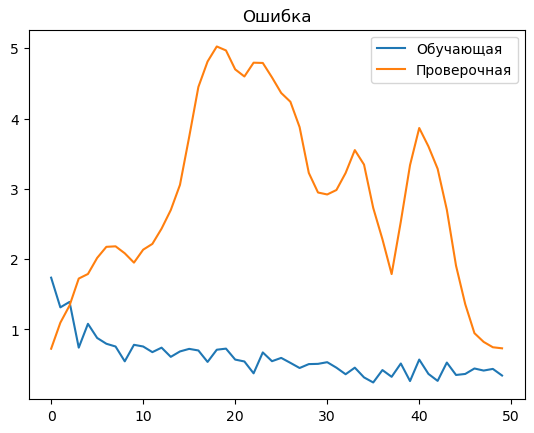

CPU times: total: 49min 2s
Wall time: 5min 8s


In [9]:
%%time
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

store = model.fit(x_data,  # ---------- ---------------- x_train, примеры набора данных
                  y_data,  # ----------- --------------- y_train, метки примеров набора данных
                  shuffle=True,  # --------------------- перемешивание данных для равномерного обучения, соответствие экземпляра и метки сохраняется 
                  batch_size=25,  # -------------------- размер пакета, который обрабатывает нейронка перед одним изменением весов
                  epochs=50,  # ------------------------ epochs - количество эпох обучения
                  validation_split=0.2,  # ------------- 0.2 - доля данных для валидационной (проверочной) выборки, 1-0.2=0.8 останется в обучающей
                  verbose=1)  # ------------------------ 0 - не визуализировать ход обучения, 1 - визуализировать
plt.plot(store.history['accuracy'], label='Обучающая')
plt.plot(store.history['val_accuracy'], label='Проверочная')
plt.legend()
plt.title('Точность')
plt.show()
plt.plot(store.history['loss'], label='Обучающая')
plt.plot(store.history['val_loss'], label='Проверочная')
plt.legend()
plt.title('Ошибка')
plt.show()

```python
print('x_test', x_test)
print('y_test', y_test)
```
```
x_test [[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...


 [[[0.48627451]
   [0.49411765]
   [0.50196078]
   ...
   [0.45882353]
   [0.43921569]
   [0.42745098]]

  [[0.53333333]
   [0.5254902 ]
   [0.52941176]
   ...
   [0.50196078]
   [0.49803922]
   [0.47843137]]

  [[0.60392157]
   [0.59215686]
   [0.59607843]
   ...
   [0.6       ]
   [0.57254902]
   [0.54117647]]

  ...
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]]
y_test [1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1]
```

1/1 [==============================] - 0s 239ms/step


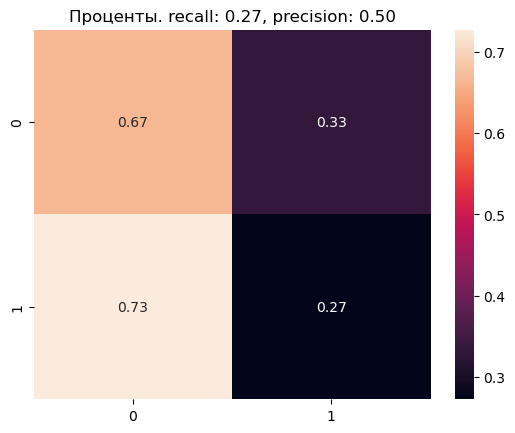

1/1 [==============================] - 0s 232ms/step


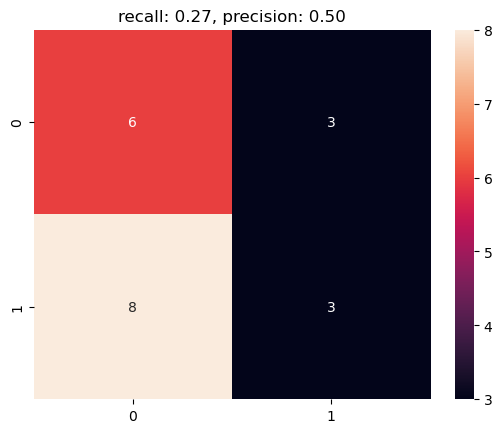

In [10]:
def test(model, x_test, y_test):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import tensorflow
    import pickle
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import confusion_matrix, precision_score, recall_score

    ##############################################################################################

    class_data = y_test
    # Кодирование меток классов индексами (числами)
    encoder = LabelEncoder()
    class_labels = encoder.fit_transform(class_data)
    CLASS_LIST = encoder.classes_
    CLASS_COUNT = len(CLASS_LIST)
    # Преобразование меток класса к векторам one hot encoding
    y = tensorflow.keras.utils.to_categorical(class_labels, CLASS_COUNT)
    y_pred = np.argmax(model.predict(x_test), axis=1)

    # проверим модель на эффективность. Выводим матрицу ошибок
    recall = ("recall: %.2f" % recall_score(y_test, y_pred))
    precision = ("precision: %.2f" % precision_score(y_test, y_pred))

    plt.title(f'Проценты. {recall}, {precision}')
    sns.heatmap(confusion_matrix(np.argmax(y, axis=1), 
                                 np.argmax(model.predict(x_test), axis=1),
                                 normalize='true'
                                ), 
                annot=True, 
               )
    plt.show()


    plt.title(f'{recall}, {precision}')
    sns.heatmap(confusion_matrix(y_test, 
                                 np.argmax(model.predict(x_test), axis=1),
                                ), 
                annot=True, 
                fmt='d', 
               )
    plt.show()
    
test(model, x_test, y_test)